In [1]:
!git clone https://github.com/nishchaybhutoria/CS203-Lab07

fatal: destination path 'CS203-Lab07' already exists and is not an empty directory.


In [2]:
%cd CS203-Lab07

/kaggle/working/CS203-Lab07


In [3]:
!pwd

/kaggle/working/CS203-Lab07


In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from transformers import AutoTokenizer, AutoModel, BitsAndBytesConfig
from torchsummary import summary

%matplotlib inline

In [5]:
torch.cuda.empty_cache()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Device: {device}")
print("PyTorch Version:", torch.__version__)
print("CUDA Available:", torch.cuda.is_available())
print("CUDA Version:", torch.version.cuda)
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))

Device: cuda
PyTorch Version: 2.5.1+cu121
CUDA Available: True
CUDA Version: 12.1
1
Tesla P100-PCIE-16GB


In [6]:
train_d1 = pd.read_csv('data/train.tsv', sep='\t', header=None)
test_d1 = pd.read_csv('data/test.tsv', sep='\t', header=None)
train_d2 = pd.read_csv('data/IMDB-Dataset.csv').head(100)

train_d1, val_d1 = train_test_split(train_d1, test_size=0.2, random_state=42)
train_d2, val_d2 = train_test_split(train_d2, test_size=0.2, random_state=42)

display(train_d1.shape, val_d1.shape, test_d1.shape, train_d2.shape, val_d2.shape)
display(train_d1.head(), val_d1.head(), train_d2.head(), val_d2.head())

vectorizer = CountVectorizer(max_features=768)
d1_bow_train = vectorizer.fit_transform(train_d1[0])

d1_bow_val = vectorizer.transform(val_d1[0])
d1_bow_test = vectorizer.transform(test_d1[0])
d2_bow_train = vectorizer.transform(train_d2["review"])
d2_bow_val = vectorizer.transform(val_d2["review"])

d1_bow_train = torch.tensor(d1_bow_train.toarray(), dtype=torch.float32)
d1_bow_val = torch.tensor(d1_bow_val.toarray(), dtype=torch.float32)
d2_bow_train = torch.tensor(d2_bow_train.toarray(), dtype=torch.float32)
d2_bow_val = torch.tensor(d2_bow_val.toarray(), dtype=torch.float32)

d1_train_y = torch.tensor(train_d1[1].values, dtype=torch.long)
d1_val_y = torch.tensor(val_d1[1].values, dtype=torch.long)

d2_train_y = torch.tensor(train_d2["sentiment"].apply(lambda x: 1 if x == "positive" else 0).values, dtype=torch.long)
d2_val_y = torch.tensor(val_d2["sentiment"].apply(lambda x: 1 if x == "positive" else 0).values, dtype=torch.long)

display(d2_train_y, d2_val_y)

print(f"Dataset 1 (Train) BoW Shape: {d1_bow_train.shape}")
print(f"Dataset 1 (Val) BoW Shape: {d1_bow_val.shape}")
print(f"Dataset 1 (Test) BoW Shape: {d1_bow_test.shape}")
print(f"IMDB (Train) BoW Shape: {d2_bow_train.shape}")
print(f"IMDB (Val) BoW Shape: {d2_bow_val.shape}")

(5536, 2)

(1384, 2)

(1821, 2)

(80, 2)

(20, 2)

,0,1
4457,graphic sex may be what 's attracting audience...,1
2471,perhaps the grossest movie ever made,0
26,"the film is moody , oozing , chilling and hear...",1
4828,watching the chemistry between freeman and jud...,1
63,the wonderfully lush morvern callar is pure pu...,1


,0,1
468,overly melodramatic,0
1956,lrb westbrook rrb makes a wonderful subject fo...,1
800,mama africa pretty much delivers on that promise,1
6474,"sad nonsense , this",0
2389,easily the most thoughtful fictional examinati...,1


,review,sentiment
55,As someone has already mentioned on this board...,negative
88,"Nicholas Walker is Paul, the local town Revera...",negative
26,"""The Cell"" is an exotic masterpiece, a dizzyin...",positive
42,"Of all the films I have seen, this one, The Ra...",negative
69,This film laboured along with some of the most...,negative


,review,sentiment
83,"""Fate"" leads Walter Sparrow to come in possess...",negative
53,I cannot believe I enjoyed this as much as I d...,positive
70,Caddyshack Two is a good movie by itself but c...,negative
45,"As a disclaimer, I've seen the movie 5-6 times...",positive
44,"This movie struck home for me. Being 29, I rem...",positive


tensor([0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1,
        0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0,
        0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0,
        0, 0, 1, 0, 0, 1, 1, 1])

tensor([0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1])

Dataset 1 (Train) BoW Shape: torch.Size([5536, 768])
Dataset 1 (Val) BoW Shape: torch.Size([1384, 768])
Dataset 1 (Test) BoW Shape: (1821, 768)
IMDB (Train) BoW Shape: torch.Size([80, 768])
IMDB (Val) BoW Shape: torch.Size([20, 768])


In [7]:
MODEL = "bert-base-uncased"

tokenizer = AutoTokenizer.from_pretrained(MODEL)
embedding_model = AutoModel.from_pretrained(MODEL).to(device)
display(embedding_model.config.hidden_size)

768

In [8]:
def get_batch_embeddings(batch_texts):
    inputs = tokenizer(
        batch_texts, return_tensors="pt", padding=True, truncation=True, max_length=512
    ).to(device)

    with torch.inference_mode():
        outputs = embedding_model(**inputs)

    return outputs.last_hidden_state.mean(dim=1).cpu().numpy()

def generate_embeddings(texts, batch_size=8):
    embeddings = []

    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i : i + batch_size]
        batch_embeddings = get_batch_embeddings(batch_texts)
        embeddings.extend(batch_embeddings)

    return torch.tensor(np.array(embeddings), dtype=torch.float32)

d1_bert_train = generate_embeddings(train_d1[0].tolist())
d1_bert_val = generate_embeddings(val_d1[0].tolist())

d2_bert_train = generate_embeddings(train_d2["review"].tolist())
d2_bert_val = generate_embeddings(val_d2["review"].tolist())

display(d1_bert_train.shape, d1_bert_val.shape, d2_bert_train.shape, d2_bert_val.shape)

torch.Size([5536, 768])

torch.Size([1384, 768])

torch.Size([80, 768])

torch.Size([20, 768])

In [9]:
from torch.utils.data import TensorDataset, DataLoader

batch_size = 8

train_d1_bow = TensorDataset(d1_bow_train, d1_train_y)
val_d1_bow = TensorDataset(d1_bow_val, d1_val_y)
train_d2_bow = TensorDataset(d2_bow_train, d2_train_y)
val_d2_bow = TensorDataset(d2_bow_val, d2_val_y)

train_d1_bert = TensorDataset(d1_bert_train, d1_train_y)
val_d1_bert = TensorDataset(d1_bert_val, d1_val_y)
train_d2_bert = TensorDataset(d2_bert_train, d2_train_y)
val_d2_bert = TensorDataset(d2_bert_val, d2_val_y)

train_d1_bow_loader = DataLoader(train_d1_bow, batch_size=batch_size, shuffle=True, pin_memory=True)
val_d1_bow_loader = DataLoader(val_d1_bow, batch_size=batch_size, shuffle=False, pin_memory=True)
train_d2_bow_loader = DataLoader(train_d2_bow, batch_size=batch_size, shuffle=True, pin_memory=True)
val_d2_bow_loader = DataLoader(val_d2_bow, batch_size=batch_size, shuffle=False, pin_memory=True)

train_d1_bert_loader = DataLoader(train_d1_bert, batch_size=batch_size, shuffle=True, pin_memory=True)
val_d1_bert_loader = DataLoader(val_d1_bert, batch_size=batch_size, shuffle=False, pin_memory=True)
train_d2_bert_loader = DataLoader(train_d2_bert, batch_size=batch_size, shuffle=True, pin_memory=True)
val_d2_bert_loader = DataLoader(val_d2_bert, batch_size=batch_size, shuffle=False, pin_memory=True)

In [10]:
criterion = nn.CrossEntropyLoss()

def train(model, optimizer, train_loader, val_loader, epochs=10, emb='bow', mode='reg'):
    model.train()

    train_loss_ = []
    val_loss_ = []
    train_acc_ = []
    val_acc_ = []
    
    for epoch in range(epochs):
        total_loss, correct, total = 0, 0, 0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()

            optimizer.step()

            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        train_acc = correct / total
        val_acc, val_loss = evaluate(model, val_loader)

        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {total_loss:.4f} | Train Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")
        
        train_loss_.append(total_loss)
        val_loss_.append(val_loss)
        train_acc_.append(train_acc)
        val_acc_.append(val_acc)

    plt.plot(np.arange(epochs), train_loss_, c='b', label='Training Loss')
    plt.plot(np.arange(epochs), val_loss_, c='r', label='Validation Loss')
    plt.title(f'Loss vs Epochs with {emb} Embeddings in {mode} Mode')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    plt.plot(np.arange(epochs), train_acc_, c='b', label='Training Accuracy')
    plt.plot(np.arange(epochs), val_acc_, c='r', label='Validation Accuracy')
    plt.title(f'Accuracy vs Epochs with {emb} Embeddings in {mode} Mode')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

def evaluate(model, loader):
    model.eval()
    total_loss, correct, total = 0, 0, 0
    
    with torch.inference_mode():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    
    return correct / total, total_loss / len(loader)

def evaluate_with_confusion_matrix(model, loader):
    model.eval()
    y_true, y_pred = [], []
    
    with torch.inference_mode():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    cm = confusion_matrix(y_true, y_pred)
    return cm, y_true, y_pred

def plot_confusion_matrix(cm, model_name):
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"Confusion Matrix for {model_name}")
    plt.show()

In [11]:
model_bow = nn.Sequential(
    nn.Linear(768, 512),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(256, 128),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(64, 2),
).to(device)

model_bert = nn.Sequential(
    nn.Linear(768, 512),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(256, 128),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(64, 2),
).to(device)

summary(model_bow, (768,))
summary(model_bert, (768,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 512]         393,728
              ReLU-2                  [-1, 512]               0
           Dropout-3                  [-1, 512]               0
            Linear-4                  [-1, 256]         131,328
              ReLU-5                  [-1, 256]               0
           Dropout-6                  [-1, 256]               0
            Linear-7                  [-1, 128]          32,896
              ReLU-8                  [-1, 128]               0
           Dropout-9                  [-1, 128]               0
           Linear-10                   [-1, 64]           8,256
             ReLU-11                   [-1, 64]               0
          Dropout-12                   [-1, 64]               0
           Linear-13                    [-1, 2]             130
Total params: 566,338
Trainable params:

Training MLP on BoW (Dataset 1)
Epoch 1/10 | Train Loss: 425.9323 | Train Acc: 0.6609 | Val Loss: 0.5470 | Val Acc: 0.7298
Epoch 2/10 | Train Loss: 330.3111 | Train Acc: 0.7673 | Val Loss: 0.5146 | Val Acc: 0.7514
Epoch 3/10 | Train Loss: 226.2655 | Train Acc: 0.8483 | Val Loss: 0.5746 | Val Acc: 0.7233
Epoch 4/10 | Train Loss: 99.4056 | Train Acc: 0.9391 | Val Loss: 1.0001 | Val Acc: 0.7197
Epoch 5/10 | Train Loss: 41.2695 | Train Acc: 0.9738 | Val Loss: 1.5209 | Val Acc: 0.7160
Epoch 6/10 | Train Loss: 32.1805 | Train Acc: 0.9810 | Val Loss: 1.3729 | Val Acc: 0.7384
Epoch 7/10 | Train Loss: 20.7979 | Train Acc: 0.9866 | Val Loss: 2.1647 | Val Acc: 0.7305
Epoch 8/10 | Train Loss: 14.3376 | Train Acc: 0.9897 | Val Loss: 2.9687 | Val Acc: 0.7175
Epoch 9/10 | Train Loss: 25.2182 | Train Acc: 0.9843 | Val Loss: 1.9423 | Val Acc: 0.7262
Epoch 10/10 | Train Loss: 18.9276 | Train Acc: 0.9874 | Val Loss: 2.1893 | Val Acc: 0.7204


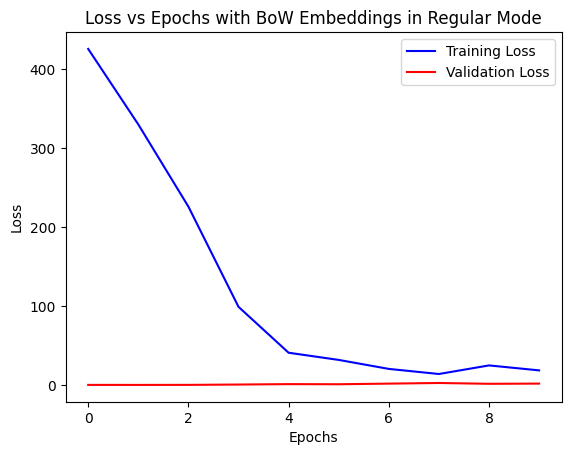

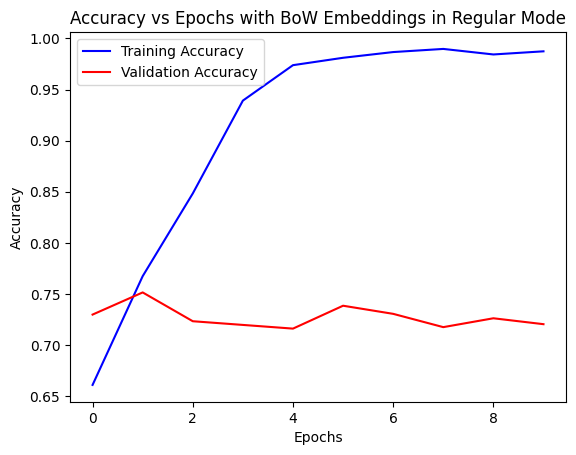

Training MLP on BERT (Dataset 1)
Epoch 1/10 | Train Loss: 307.0670 | Train Acc: 0.7859 | Val Loss: 0.3121 | Val Acc: 0.8483
Epoch 2/10 | Train Loss: 231.1507 | Train Acc: 0.8540 | Val Loss: 0.3188 | Val Acc: 0.8707
Epoch 3/10 | Train Loss: 218.1128 | Train Acc: 0.8634 | Val Loss: 0.3163 | Val Acc: 0.8663
Epoch 4/10 | Train Loss: 202.2206 | Train Acc: 0.8781 | Val Loss: 0.2904 | Val Acc: 0.8757
Epoch 5/10 | Train Loss: 189.1317 | Train Acc: 0.8867 | Val Loss: 0.3723 | Val Acc: 0.8678
Epoch 6/10 | Train Loss: 170.4311 | Train Acc: 0.8927 | Val Loss: 0.3644 | Val Acc: 0.8461
Epoch 7/10 | Train Loss: 151.5760 | Train Acc: 0.9100 | Val Loss: 0.3264 | Val Acc: 0.8721
Epoch 8/10 | Train Loss: 138.4269 | Train Acc: 0.9198 | Val Loss: 0.3549 | Val Acc: 0.8685
Epoch 9/10 | Train Loss: 115.0076 | Train Acc: 0.9279 | Val Loss: 0.5007 | Val Acc: 0.8555
Epoch 10/10 | Train Loss: 96.8905 | Train Acc: 0.9438 | Val Loss: 0.4258 | Val Acc: 0.8634


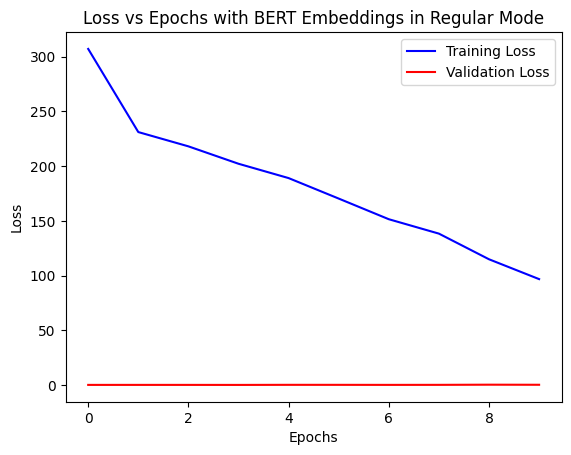

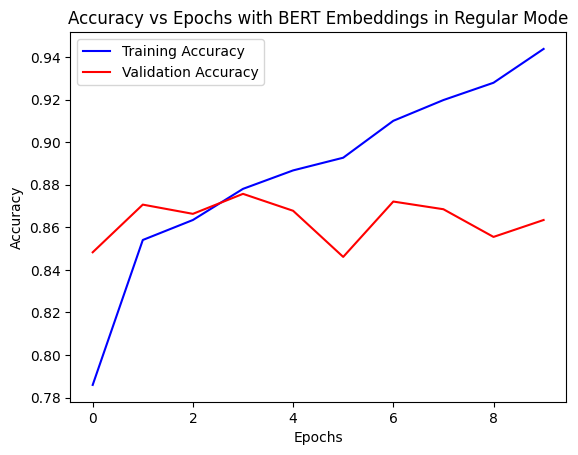

Fine-tuning MLP on BoW (IMDB)
Epoch 1/10 | Train Loss: 57.3793 | Train Acc: 0.7250 | Val Loss: 8.5879 | Val Acc: 0.5000
Epoch 2/10 | Train Loss: 45.0180 | Train Acc: 0.7500 | Val Loss: 7.2337 | Val Acc: 0.6000
Epoch 3/10 | Train Loss: 37.3103 | Train Acc: 0.8000 | Val Loss: 6.2969 | Val Acc: 0.6500
Epoch 4/10 | Train Loss: 30.5099 | Train Acc: 0.8125 | Val Loss: 5.7551 | Val Acc: 0.6500
Epoch 5/10 | Train Loss: 24.6248 | Train Acc: 0.8125 | Val Loss: 5.2782 | Val Acc: 0.6500
Epoch 6/10 | Train Loss: 20.1452 | Train Acc: 0.8125 | Val Loss: 5.0207 | Val Acc: 0.6500
Epoch 7/10 | Train Loss: 16.3916 | Train Acc: 0.8125 | Val Loss: 4.7756 | Val Acc: 0.6500
Epoch 8/10 | Train Loss: 13.3010 | Train Acc: 0.8500 | Val Loss: 4.6524 | Val Acc: 0.6500
Epoch 9/10 | Train Loss: 11.3610 | Train Acc: 0.8875 | Val Loss: 4.3952 | Val Acc: 0.6500
Epoch 10/10 | Train Loss: 9.9407 | Train Acc: 0.8875 | Val Loss: 4.2659 | Val Acc: 0.6500


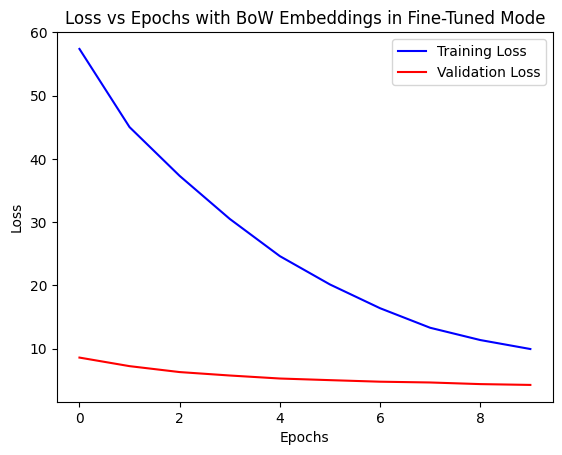

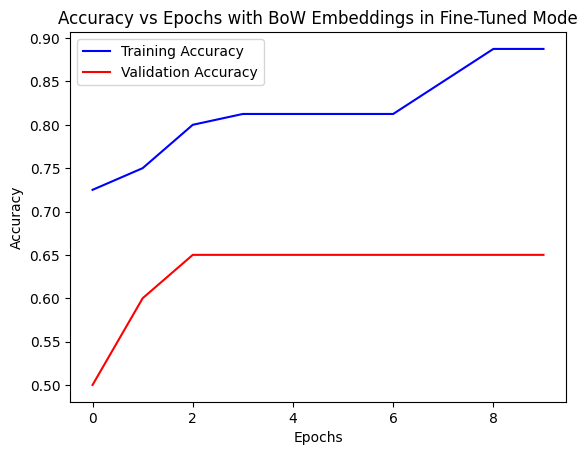

Fine-tuning MLP on BERT (IMDB)
Epoch 1/10 | Train Loss: 2.2171 | Train Acc: 0.9250 | Val Loss: 0.2090 | Val Acc: 0.9000
Epoch 2/10 | Train Loss: 1.6063 | Train Acc: 0.9375 | Val Loss: 0.2119 | Val Acc: 0.9000
Epoch 3/10 | Train Loss: 1.4496 | Train Acc: 0.9375 | Val Loss: 0.2183 | Val Acc: 0.9000
Epoch 4/10 | Train Loss: 1.3231 | Train Acc: 0.9375 | Val Loss: 0.2290 | Val Acc: 0.9000
Epoch 5/10 | Train Loss: 1.1888 | Train Acc: 0.9375 | Val Loss: 0.2449 | Val Acc: 0.9000
Epoch 6/10 | Train Loss: 1.0638 | Train Acc: 0.9375 | Val Loss: 0.2632 | Val Acc: 0.9000
Epoch 7/10 | Train Loss: 0.9379 | Train Acc: 0.9375 | Val Loss: 0.2772 | Val Acc: 0.9000
Epoch 8/10 | Train Loss: 0.7757 | Train Acc: 0.9750 | Val Loss: 0.2972 | Val Acc: 0.9000
Epoch 9/10 | Train Loss: 0.6772 | Train Acc: 0.9750 | Val Loss: 0.3135 | Val Acc: 0.9000
Epoch 10/10 | Train Loss: 0.5564 | Train Acc: 0.9875 | Val Loss: 0.3539 | Val Acc: 0.9000


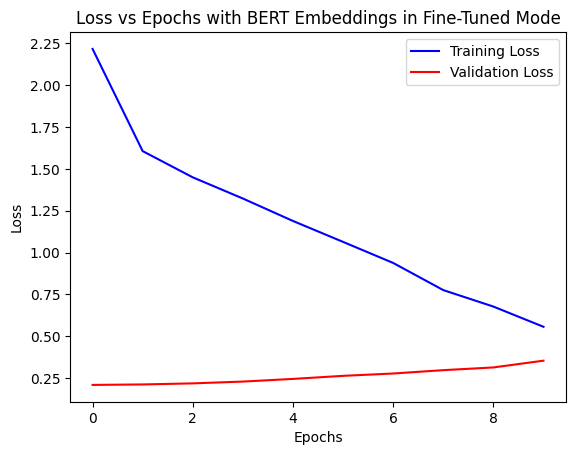

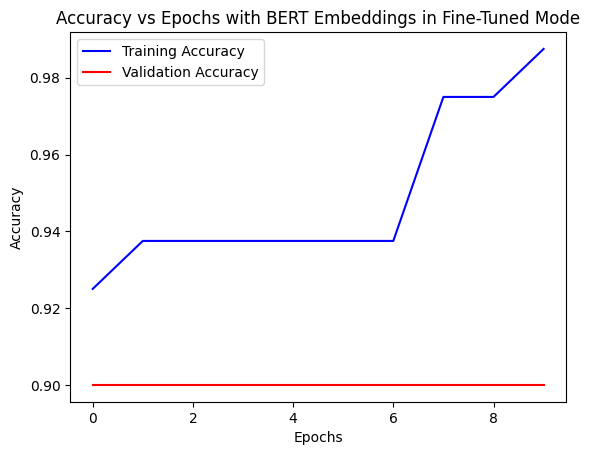

Saved final models


In [12]:
pretrain_lr = 0.001  
finetune_lr = 0.0001  

optimizer_bow = optim.Adam(model_bow.parameters(), lr=pretrain_lr)
optimizer_bert = optim.Adam(model_bert.parameters(), lr=pretrain_lr)

print("Training MLP on BoW (Dataset 1)")
train(model_bow, optimizer_bow, train_d1_bow_loader, val_d1_bow_loader, epochs=10, emb='BoW', mode='Regular')

print("Training MLP on BERT (Dataset 1)")
train(model_bert, optimizer_bert, train_d1_bert_loader, val_d1_bert_loader, epochs=10, emb='BERT', mode='Regular')

torch.save(model_bow.state_dict(), "best_model_bow.pt")
torch.save(model_bert.state_dict(), "best_model_bert.pt")

model_bow.load_state_dict(torch.load("best_model_bow.pt", weights_only=True))
model_bert.load_state_dict(torch.load("best_model_bert.pt", weights_only=True))

optimizer_bow = optim.Adam(model_bow.parameters(), lr=finetune_lr)
optimizer_bert = optim.Adam(model_bert.parameters(), lr=finetune_lr)

print("Fine-tuning MLP on BoW (IMDB)")
train(model_bow, optimizer_bow, train_d2_bow_loader, val_d2_bow_loader, epochs=10, emb='BoW', mode='Fine-Tuned')

print("Fine-tuning MLP on BERT (IMDB)")
train(model_bert, optimizer_bert, train_d2_bert_loader, val_d2_bert_loader, epochs=10, emb='BERT', mode='Fine-Tuned')

torch.save(model_bow.state_dict(), "final_model_bow.pt")
torch.save(model_bert.state_dict(), "final_model_bert.pt")

print("Saved final models")

IMDB Validation Results (BoW Model): Accuracy = 0.6500, Loss = 4.2659
IMDB Validation Results (BERT Model): Accuracy = 0.9000, Loss = 0.3539


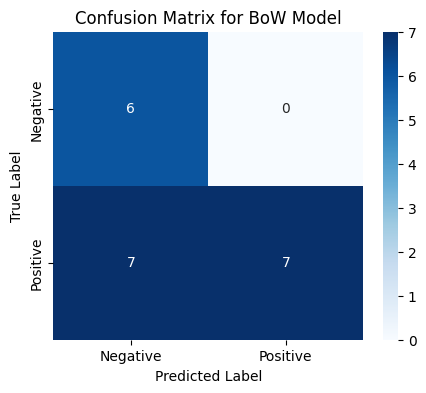

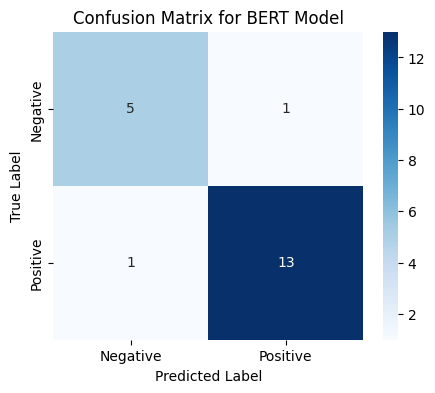

In [13]:
model_bow.load_state_dict(torch.load("final_model_bow.pt", weights_only=True))
model_bert.load_state_dict(torch.load("final_model_bert.pt", weights_only=True))

bow_imdb_val_acc, bow_imdb_val_loss = evaluate(model_bow, val_d2_bow_loader)
bert_imdb_val_acc, bert_imdb_val_loss = evaluate(model_bert, val_d2_bert_loader)

print(f"IMDB Validation Results (BoW Model): Accuracy = {bow_imdb_val_acc:.4f}, Loss = {bow_imdb_val_loss:.4f}")
print(f"IMDB Validation Results (BERT Model): Accuracy = {bert_imdb_val_acc:.4f}, Loss = {bert_imdb_val_loss:.4f}")

bow_cm, bow_y_true, bow_y_pred = evaluate_with_confusion_matrix(model_bow, val_d2_bow_loader)
bert_cm, bert_y_true, bert_y_pred = evaluate_with_confusion_matrix(model_bert, val_d2_bert_loader)

plot_confusion_matrix(bow_cm, "BoW Model")
plot_confusion_matrix(bert_cm, "BERT Model")